In [1]:
import cv2
import numpy as np
import scipy.sparse.linalg

import utils

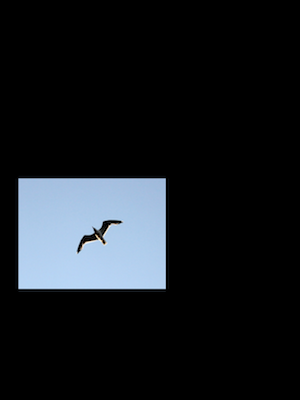

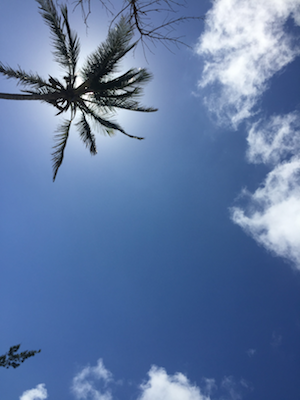

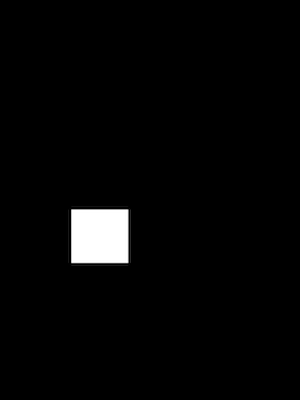

In [2]:
# change the second number in the path to see different examples
# to change the type of cloning (mixing or max) go to the end of the notebook
folder_path = "img/archive (2)/1/" 

source = utils.open_and_print_image(folder_path + "source")

target = utils.open_and_print_image(folder_path + "target")

mask = utils.open_and_print_image(folder_path + "mask", is_mask=True)


In [3]:
height, width, mask, inner_mask, boundary_mask, pixel_ids, inner_ids, boundary_ids, mask_ids, inner_pos, boundary_pos, mask_pos = utils.setup_variables(mask)
channels = 3

In [4]:
A = utils.create_matrix_A(mask_ids, inner_ids, boundary_ids, inner_pos, boundary_pos, width)

In [5]:
def compute_mixed_gradients(src, target, mode="max", alpha=1.0):
    #
    if mode == "max":
        # compute the gradient (forward and backward)
        # of the source and target images and take the maximum at each pixel
        I_x_src, I_y_src = utils.compute_gradient(src)
        I_x_target, I_y_target = utils.compute_gradient(target)
        # norm of the gradient
        I_src_amp = (I_x_src**2 + I_y_src**2)**0.5
        I_target_amp = (I_x_target**2 + I_y_target**2)**0.5
        # take the maximum at each pixel
        I_x = np.where(I_src_amp > I_target_amp, I_x_src, I_x_target)
        I_y = np.where(I_src_amp > I_target_amp, I_y_src, I_y_target)
        # compute the backward gradient of the maximum gradient
        I_xx, _ = utils.compute_gradient(I_x, forward=False)
        _, I_yy = utils.compute_gradient(I_y, forward=False)
        return I_xx + I_yy
    elif mode == "alpha":
        # complute the laplacian of the source and target images and mix them 
        src_laplacian = utils.compute_laplacian(src)
        target_laplacian = utils.compute_laplacian(target)
        return alpha * src_laplacian + (1 - alpha) * target_laplacian
    

In [6]:
def poisson_blend_channel(src, target, gradient_mixing_mode, gradient_mixing_alpha):
    #compute the gradient 
    mixed_gradients = compute_mixed_gradients(src, target, gradient_mixing_mode, gradient_mixing_alpha)
    
    boundary_pixel_values = utils.get_masked_values(target, boundary_mask).flatten()
    inner_gradient_values = utils.get_masked_values(mixed_gradients, inner_mask).flatten()

    # Construct b
    b = utils.construct_b(mask_ids, inner_pos, boundary_pos, inner_gradient_values, boundary_pixel_values)

    # Solve Ax = b
    x = scipy.sparse.linalg.spsolve(A, b)

    # reconstruct the new image (single channel)
    new_src = np.zeros_like(src)
    new_src.flat[mask_pos] = x
    poisson_blended_img = utils.get_alpha_blended(new_src, target, mask)
    poisson_blended_img = np.clip(poisson_blended_img, 0, 1)
    
    return poisson_blended_img

In [7]:
# calls the algorithm for each color channel
def poisson_blend(gradient_mixing_mode, gradient_mixing_alpha):
    return np.dstack([poisson_blend_channel(source[..., i], target[..., i], gradient_mixing_mode, gradient_mixing_alpha) for i in range(source.shape[-1])])

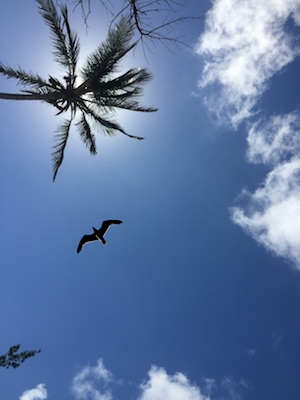

In [8]:
# max for maximum and alpha for alpha blending (mixing)
gr_mix_mode = "max" # max or alpha
# if alpha is selected then the alpha value can be changed [0, 1]
gr_mix_alpha = 1
img = poisson_blend(gr_mix_mode, gr_mix_alpha)
    
utils.save_and_print(img, folder_path, "result.png")
